In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Preprocessing of Hyperspectral Images

In [3]:
!pip install rasterio
!pip install spectral


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 63.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.0/249.0 kB 5.7 MB/s eta 0:00:0000:01


In [4]:
import os
import numpy as np
import rasterio
import cv2
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Define dataset paths
raw_dataset_path = "/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2024/archive"  
processed_dataset_path = "/kaggle/working/processed_images"
os.makedirs(processed_dataset_path, exist_ok=True)

# Standard shape for hyperspectral processing
TARGET_SIZE = (128, 128)  # Resize to 128x128
SELECTED_BANDS = 100  # Number of spectral bands to keep

# Function to process a single hyperspectral image
def process_hyperspectral_image(image_path):
    with rasterio.open(image_path) as img:
        hyperspectral_data = img.read()  # Shape: (Bands, Height, Width)
    
    # Normalize each band separately
    hyperspectral_data = hyperspectral_data.astype(np.float32)
    for i in range(hyperspectral_data.shape[0]):  # Iterate over bands
        min_val = hyperspectral_data[i].min()
        max_val = hyperspectral_data[i].max()
        if max_val > min_val:
            hyperspectral_data[i] = (hyperspectral_data[i] - min_val) / (max_val - min_val)

    # Perform band selection (Take first 50 bands or use PCA if needed)
    if hyperspectral_data.shape[0] > SELECTED_BANDS:
        hyperspectral_data = hyperspectral_data[:SELECTED_BANDS, :, :]

    # Resize each band separately
    resized_bands = np.zeros((SELECTED_BANDS, TARGET_SIZE[0], TARGET_SIZE[1]))
    for i in range(SELECTED_BANDS):
        resized_bands[i] = cv2.resize(hyperspectral_data[i], TARGET_SIZE, interpolation=cv2.INTER_CUBIC)
    
    return resized_bands  # Shape: (50, 128, 128)

# Process entire dataset
all_images = []
all_labels = []

for category in os.listdir(os.path.join(raw_dataset_path, "train")):  # Using "train" folder as full dataset
    category_path = os.path.join(raw_dataset_path, "train", category)
    os.makedirs(os.path.join(processed_dataset_path, category), exist_ok=True)

    for img_path in tqdm(glob(os.path.join(category_path, "*.tif")), desc=f"Processing {category}"):
        processed_image = process_hyperspectral_image(img_path)
        
        # Save as .npy file
        save_path = os.path.join(processed_dataset_path, category, os.path.basename(img_path).replace(".tif", ".npy"))
        np.save(save_path, processed_image)

        all_images.append(save_path)
        all_labels.append(category)

print(f"✅ Processed {len(all_images)} images! Stored in {processed_dataset_path}")


Processing Rust: 100%|██████████| 200/200 [00:11<00:00, 17.59it/s]

✅ Processed 600 images! Stored in /kaggle/working/processed_images


In [5]:
# Split dataset into train (80%), val (10%), and test (10%)
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=42)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Create new directories
split_dataset_path = "/kaggle/working/split_dataset"
for split in ["train", "val", "test"]:
    for category in os.listdir(processed_dataset_path):
        os.makedirs(os.path.join(split_dataset_path, split, category), exist_ok=True)

# Function to move files to split directories
import shutil

def move_files(image_paths, labels, split_name):
    for img_path, label in zip(image_paths, labels):
        dest_path = os.path.join(split_dataset_path, split_name, label, os.path.basename(img_path))
        shutil.move(img_path, dest_path)

# Move processed files to split directories
move_files(train_imgs, train_labels, "train")
move_files(val_imgs, val_labels, "val")
move_files(test_imgs, test_labels, "test")

print(f"✅ Dataset split completed! Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")


✅ Dataset split completed! Train: 480, Val: 60, Test: 60


## Making RGB Images

In [23]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import shutil

# Define source and destination directories for split data
split_dataset_path = "/kaggle/working/split_dataset"
rgb_split_dataset_path = "/kaggle/working/rgb_split_dataset"
os.makedirs(rgb_split_dataset_path, exist_ok=True)

# Create corresponding folder structure for RGB images
for split in ["train", "val", "test"]:
    split_path = os.path.join(split_dataset_path, split)
    rgb_split_path = os.path.join(rgb_split_dataset_path, split)
    os.makedirs(rgb_split_path, exist_ok=True)
    
    # For every category folder in this split:
    for category in os.listdir(split_path):
        category_dir = os.path.join(split_path, category)
        if os.path.isdir(category_dir):
            rgb_category_dir = os.path.join(rgb_split_path, category)
            os.makedirs(rgb_category_dir, exist_ok=True)

def hsi_to_rgb(hsi_image, r_idx=42, g_idx=15, b_idx=0):
    """
    Convert hyperspectral image (shape: (channels, H, W)) to a pseudo-RGB image using band selection.
    
    The three chosen indices are arbitrary and should be tailored to your sensor.
    """
    # Ensure hsi_image is a numpy array
    if isinstance(hsi_image, (list, tuple)):
        hsi_image = np.array(hsi_image)
    
    # hsi_image is assumed to be normalized to [0,1]
    # Extract the three bands (shape: (H, W))
    try:
        red_band   = hsi_image[r_idx]
        green_band = hsi_image[g_idx]
        blue_band  = hsi_image[b_idx]
    except IndexError:
        raise ValueError("Chosen band indices are out of bounds for the image with shape {}".format(hsi_image.shape))
    
    # Stack into RGB (H, W, 3)
    rgb = np.stack([red_band, green_band, blue_band], axis=-1)
    
    # Optional: clip or re-normalize if needed
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)  # Back to [0,1]
    rgb = (rgb * 255).astype(np.uint8)  # Convert to 8-bit image
    return rgb

# Loop over the split directories and convert/save RGB images
for split in ["train", "val", "test"]:
    split_path = os.path.join(split_dataset_path, split)
    rgb_split_path = os.path.join(rgb_split_dataset_path, split)
    for category in os.listdir(split_path):
        category_dir = os.path.join(split_path, category)
        if not os.path.isdir(category_dir):
            continue
        rgb_category_dir = os.path.join(rgb_split_path, category)
        for file in tqdm(os.listdir(category_dir), desc=f"Converting {split}/{category}"):
            if file.endswith(".npy"):
                hsi_path = os.path.join(category_dir, file)
                # Load the hyperspectral image (shape: (50, 128, 128))
                hsi_img = np.load(hsi_path)
                # Convert to RGB
                rgb_img = hsi_to_rgb(hsi_img)
                # Save as PNG file
                rgb_save_path = os.path.join(rgb_category_dir, file.replace(".npy", ".png"))
                cv2.imwrite(rgb_save_path, cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR))  # OpenCV expects BGR order

print("✅ RGB conversion completed!")


Converting test/Rust: 100%|██████████| 20/20 [00:00<00:00, 274.86it/s]

✅ RGB conversion completed!


In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class DualModalityDataset(Dataset):
    def __init__(self, hsi_root, rgb_root, transform_hsi=None, transform_rgb=None):
        """
        Args:
            hsi_root (str): Root directory of hyperspectral images (e.g., /kaggle/working/split_dataset/train)
            rgb_root (str): Root directory of RGB images (e.g., /kaggle/working/rgb_split_dataset/train)
            transform_hsi (callable, optional): Transformation to apply to the hyperspectral tensor.
            transform_rgb (callable, optional): Transformation to apply to the RGB image (PIL/Image tensor).
        """
        self.samples = []
        self.transform_hsi = transform_hsi
        self.transform_rgb = transform_rgb
        
        # Walk over each category folder in hsi_root
        for category in sorted(os.listdir(hsi_root)):
            hsi_category_path = os.path.join(hsi_root, category)
            rgb_category_path = os.path.join(rgb_root, category)
            if not os.path.isdir(hsi_category_path):
                continue
            # List all files in the HSI folder
            for filename in os.listdir(hsi_category_path):
                if filename.endswith(".npy"):
                    hsi_path = os.path.join(hsi_category_path, filename)
                    # Assume matching RGB file has same base filename with .png extension
                    rgb_path = os.path.join(rgb_category_path, filename.replace(".npy", ".png"))
                    # Only add if the RGB image exists
                    if os.path.exists(rgb_path):
                        self.samples.append((hsi_path, rgb_path, category))
        
        # Create a mapping from category to an index
        categories = sorted({s[2] for s in self.samples})
        self.cat2idx = {cat: idx for idx, cat in enumerate(categories)}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        hsi_path, rgb_path, category = self.samples[idx]
        # Load hyperspectral image (stored as .npy, shape (50, 128, 128))
        hsi_img = np.load(hsi_path)
        # Convert to torch tensor (float32)
        hsi_tensor = torch.tensor(hsi_img, dtype=torch.float32)
        if self.transform_hsi:
            hsi_tensor = self.transform_hsi(hsi_tensor)
        
        # Load RGB image using PIL (to allow use of torchvision transforms)
        rgb_img = Image.open(rgb_path).convert("RGB")
        if self.transform_rgb:
            rgb_img = self.transform_rgb(rgb_img)
        else:
            # By default, convert the image to tensor in [0, 1]
            from torchvision.transforms import ToTensor
            rgb_img = ToTensor()(rgb_img)
        
        label = self.cat2idx[category]
        return hsi_tensor, rgb_img, label


In [25]:
import os
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch
import torchvision.transforms.functional as TF

# Custom resize transform for hyperspectral data (if tensor input)

#transform_hsi = TensorResize((224, 224))  # Match both HSI and RGB resolutions
transform_rgb = T.Compose([
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),  # Random vertical flip
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    T.RandomRotation(30),  # Random rotation by up to 30 degrees
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformation
    T.RandomCrop(128, padding=8),  # Random crop with padding
    T.RandomPerspective(distortion_scale=0.2, p=0.5),  # Random perspective transformation
    T.GaussianBlur(kernel_size=5),  # Apply Gaussian blur
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pre-trained models
])



# Define root directories for each split
hsi_train_root = os.path.join(split_dataset_path, "train")
rgb_train_root = os.path.join(rgb_split_dataset_path, "train")

hsi_val_root = os.path.join(split_dataset_path, "val")
rgb_val_root = os.path.join(rgb_split_dataset_path, "val")

hsi_test_root = os.path.join(split_dataset_path, "test")
rgb_test_root = os.path.join(rgb_split_dataset_path, "test")

# Instantiate datasets
train_dataset = DualModalityDataset(hsi_root=hsi_train_root, rgb_root=rgb_train_root,
                                    transform_hsi=transform_hsi, transform_rgb=transform_rgb)

val_dataset = DualModalityDataset(hsi_root=hsi_val_root, rgb_root=rgb_val_root,
                                  transform_hsi=transform_hsi, transform_rgb=transform_rgb)

test_dataset = DualModalityDataset(hsi_root=hsi_test_root, rgb_root=rgb_test_root,
                                   transform_hsi=transform_hsi, transform_rgb=transform_rgb)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Quick sanity check
for hsi_batch, rgb_batch, labels in val_loader:
    print("Val HSI batch shape:", hsi_batch.shape)
    print("Val RGB batch shape:", rgb_batch.shape)
    print("Val Labels:", labels)
    break


Val HSI batch shape: torch.Size([32, 100, 224, 224])
Val RGB batch shape: torch.Size([32, 3, 128, 128])
Val Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


### Doing SSL

In [9]:
import os
import shutil

# Paths
split_dataset_path = "/kaggle/working/split_dataset"  # Where train/val/test exist
ssl_dataset_path = "/kaggle/working/ssl_dataset"  # New dataset for SSL

# Create SSL dataset directory
os.makedirs(ssl_dataset_path, exist_ok=True)

# Merge all splits into SSL dataset
for split in ["train", "val", "test"]:
    split_path = os.path.join(split_dataset_path, split)
    if not os.path.exists(split_path):
        continue  # Skip if path doesn't exist

    for category in os.listdir(split_path):  # Loop over classes (Health, Rust, Other)
        category_path = os.path.join(ssl_dataset_path, category)
        os.makedirs(category_path, exist_ok=True)  # Ensure class folder exists

        # Move all images to the SSL dataset
        for file in os.listdir(os.path.join(split_path, category)):
            src = os.path.join(split_path, category, file)
            dest = os.path.join(category_path, file)
            shutil.move(src, dest)

print(f"✅ SSL dataset is ready in {ssl_dataset_path}")


✅ SSL dataset is ready in /kaggle/working/ssl_dataset


### Data Augmentation for SSL

In [10]:
import numpy as np
import albumentations as A
import cv2
import os
from glob import glob

# Define augmentations
augmentations = A.Compose([
    A.RandomCrop(height=128, width=128, always_apply=True),  # Crop to 128x128
    A.HorizontalFlip(p=0.5),  # Flip 50% of the time
    A.VerticalFlip(p=0.5),  # Flip 50% of the time
])

# Function to apply augmentation
def apply_augmentations(img_path):
    img = np.load(img_path)  # Load .npy file
    img = np.float32(img)  # Ensure correct dtype for Albumentations
    
    # Normalize if needed (optional, depending on your dataset)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)  # Scale to 0-255
    img = img.astype(np.uint8)  # Convert to uint8 if necessary

    # Albumentations expects HWC format, so ensure the correct shape
    if img.ndim == 2:  
        img = np.expand_dims(img, axis=-1)  # Convert grayscale to HWC
    elif img.shape[0] < img.shape[-1]:  # If channels are first, swap axes
        img = np.transpose(img, (1, 2, 0))

    augmented = augmentations(image=img)["image"]  # Apply augmentations
    
    return augmented

# Apply augmentations to SSL dataset
for class_folder in os.listdir(ssl_dataset_path):
    class_path = os.path.join(ssl_dataset_path, class_folder)
    if not os.path.isdir(class_path):  # Skip non-folder items
        continue

    for img_path in glob(os.path.join(class_path, "*.npy")):
        augmented_img = apply_augmentations(img_path)
        np.save(img_path.replace(".npy", "_aug.npy"), augmented_img)  # Save augmented image

print("✅ Augmentations applied to SSL dataset!")


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


✅ Augmentations applied to SSL dataset!


### SSL Training with SimCLR

### AHAM Addition

NTXent loss - Loss function for SimCLR encoder

In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from timm.models import create_model  

# -------------------------
# GPU/Memory Setup
# -------------------------
torch.cuda.empty_cache()
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = True
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:64'

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------
# Define AHAM Module
# -------------------------
class AHAM(nn.Module):
    """
    Adaptive Hyperspectral Attention Module (AHAM).
    Expects input x of shape [B, P, D] where:
      B = batch size,
      P = number of tokens/patches,
      D = embedding dimension.
    Returns a weighted average over tokens (i.e. a refined feature vector)
    and the attention weights (for visualization).
    """
    def __init__(self, embed_dim, reduction=16):
        super(AHAM, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(embed_dim, embed_dim // reduction)
        self.fc2 = nn.Linear(embed_dim // reduction, embed_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: [B, P, D]
        attention = self.avg_pool(x.transpose(1, 2)).squeeze(-1)  # [B, D]
        attention = self.fc1(attention)
        attention = nn.functional.relu(attention)
        attention = self.fc2(attention)
        attention = self.sigmoid(attention)  # [B, D]
        x_weighted = (x * attention.unsqueeze(1)).mean(dim=1)  # [B, D]
        return x_weighted, attention

Using device: cuda:1


In [13]:
# -------------------------
# Define NT-Xent Loss (Contrastive Loss)
# -------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

class NTXentLossFull(nn.Module):
    """
    A full NT-Xent loss where each sample is compared against all in the batch
    (2B in total, minus itself).
    This is the canonical approach in SimCLR.
    """
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        """
        z_i: [B, D]
        z_j: [B, D]
        Returns scalar contrastive loss.
        """
        # If the inputs are 1D, unsqueeze them to add the batch dimension.
        # if z_i.dim() == 1:
        #     z_i = z_i.unsqueeze(0)
        # if z_j.dim() == 1:
        #     z_j = z_j.unsqueeze(0)
        
        # z_i = z_i.float()
        # z_j = z_j.float()
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)

        # Concatenate along batch dimension
        z = torch.cat([z_i, z_j], dim=0)  # [2B, D]

        # Compute similarity matrix
        sim_matrix = torch.matmul(z, z.T)  # [2B, 2B]

        # Create labels for positives:
        # For sample i in [0..B-1], the positive is i+B
        # For sample i in [B..2B-1], the positive is i-B
        batch_size = z_i.size(0)
        labels = torch.arange(batch_size, device=z.device)
        labels = torch.cat([labels + batch_size, labels], dim=0)  # [2B]

        # Mask out self-similarity by setting the diagonal to large negative
        mask = torch.eye(2 * batch_size, device=z.device).bool()
        sim_matrix.masked_fill_(mask, -9e15)

        # Scale by temperature
        sim_matrix /= self.temperature

        # Use cross-entropy over the row to find the positive sample.
        loss = F.cross_entropy(sim_matrix, labels)
        return loss



criterion = NTXentLossFull()

In [14]:
# -------------------------
# Define the SimCLR Model with AHAM Integrated
# -------------------------
class SimCLR(nn.Module):
    def __init__(self, backbone="vit_base_patch16_224", feature_dim=128, input_channels=100):
        """
        backbone: name of the backbone ViT model.
        feature_dim: Final embedding dimension for contrastive learning.
        input_channels: Number of channels in the hyperspectral input.
        """
        super(SimCLR, self).__init__()
        # Create the ViT model without classifier.
        # Remove 'output_cls_token' because it is not supported.
        self.encoder = create_model(backbone, pretrained=False, num_classes=0)
        
        # Modify patch embedding projection layer to accept input_channels
        new_conv_layer = nn.Conv2d(
            input_channels,
            self.encoder.patch_embed.proj.out_channels,
            kernel_size=self.encoder.patch_embed.proj.kernel_size,
            stride=self.encoder.patch_embed.proj.stride,
            padding=self.encoder.patch_embed.proj.padding,
            bias=False
        )
        self.encoder.patch_embed.proj = new_conv_layer

        # Integrate AHAM.
        self.aham = AHAM(embed_dim=self.encoder.num_features)
        # Project refined features to contrastive embedding space.
        self.projector = nn.Sequential(
            nn.Linear(self.encoder.num_features, 512),
            nn.ReLU(),
            nn.Linear(512, feature_dim)
        )

    def forward(self, x, return_attention=False):
        # Get token embeddings from the encoder; x shape: [B, input_channels, 224, 224]
        tokens = self.encoder.forward_features(x)  # Output shape: [B, P, D]
        x_weighted, attention = self.aham(tokens)      # [B, D] and [B, D]
        projections = self.projector(x_weighted)
        if return_attention:
            return projections, attention
        return projections

hsi_model = SimCLR(input_channels=100).to(device)
hsi_model.train()
print("✅ SimCLR with AHAM is ready!")

✅ SimCLR with AHAM is ready!


In [15]:
# -------------------------
# Define Custom Transforms for the SSL Dataset
# -------------------------
class RandomHorizontalFlipTensor:
    """Randomly horizontally flips a tensor image with probability p."""
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, img):
        if torch.rand(1).item() < self.p:
            return torch.flip(img, dims=[-1])
        return img

class RandomVerticalFlipTensor:
    """Randomly vertically flips a tensor image with probability p."""
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, img):
        if torch.rand(1).item() < self.p:
            return torch.flip(img, dims=[-2])
        return img

class RandomRotationTensor:
    """Randomly rotates a tensor image by an angle between -max_angle and max_angle degrees."""
    def __init__(self, max_angle=30):
        self.max_angle = max_angle
    def __call__(self, img):
        angle = torch.empty(1).uniform_(-self.max_angle, self.max_angle).item()
        return TF.rotate(img, angle)

class AddGaussianNoise:
    """Adds Gaussian noise to a tensor image."""
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std
    def __call__(self, img):
        noise = torch.randn_like(img) * self.std + self.mean
        return img + noise

class RandomContrastTensor:
    """Randomly adjusts contrast for a tensor image by a factor chosen uniformly."""
    def __init__(self, lower=0.7, upper=1.3):
        self.lower = lower
        self.upper = upper
    def __call__(self, img):
        factor = torch.empty(1).uniform_(self.lower, self.upper).item()
        mean = torch.mean(img, dim=[1,2], keepdim=True)
        return (img - mean) * factor + mean

class TensorResize:
    """Resizes a tensor image to the target size."""
    def __init__(self, size):
        self.size = size
    def __call__(self, img):
        return torch.nn.functional.interpolate(
            img.unsqueeze(0), size=self.size, mode='bilinear', align_corners=False
        ).squeeze(0)

# Compose an augmentation pipeline with many augmentations.
transform = T.Compose([
    TensorResize((224, 224)),
    RandomHorizontalFlipTensor(p=0.5),
    RandomVerticalFlipTensor(p=0.5),
    RandomRotationTensor(max_angle=30),
    AddGaussianNoise(mean=0.0, std=0.05),
    RandomContrastTensor(lower=0.8, upper=1.2)
])

# -------------------------
# Define the SSL Dataset for Contrastive Learning
# -------------------------
class SSLDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_channels=100):
        self.root_dir = root_dir
        self.transform = transform
        self.target_channels = target_channels
        self.image_paths = [
            os.path.join(root, f)
            for root, _, files in os.walk(root_dir)
            for f in files if f.endswith(".npy")
        ]
        print(f"Found {len(self.image_paths)} hyperspectral images in {root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = np.load(img_path)  # Load hyperspectral image (H, W, C)
        if len(img.shape) == 2:
            raise ValueError(f"Image at {img_path} is grayscale (expected HxWxC).")
        C, H, W = img.shape[2], img.shape[0], img.shape[1]
        if C < self.target_channels:
            img_padded = np.zeros((H, W, self.target_channels), dtype=np.float32)
            img_padded[:, :, :C] = img
            img = img_padded
        elif C > self.target_channels:
            img = img[:, :, :self.target_channels]
        img = np.transpose(img, (2, 0, 1)).astype(np.float32)
        img_min, img_max = img.min(), img.max()
        if img_max > img_min:
            img = (img - img_min) / (img_max - img_min)
        else:
            img = np.zeros_like(img)
        img_tensor = torch.tensor(img, dtype=torch.float32)
        # Generate two different augmented views.
        if self.transform:
            view1 = self.transform(img_tensor)
            view2 = self.transform(img_tensor)
        else:
            view1, view2 = img_tensor, img_tensor
        return view1, view2

# -------------------------
# Instantiate the Dataset and DataLoader
# -------------------------
# Update this path to point to your hyperspectral .npy files.
#ssl_dataset_path = "/path/to/hsi_dataset"
ssl_dataset = SSLDataset(ssl_dataset_path, transform)
ssl_loader = DataLoader(ssl_dataset, batch_size=32, shuffle=True, num_workers=2)

# -------------------------
# Define the Optimizer
# -------------------------
optimizer = optim.Adam(hsi_model.parameters(), lr=3e-4)

# -------------------------
# Training Loop for Self-Supervised Learning (with AHAM integrated)
# -------------------------
num_epochs = 10
for epoch in range(num_epochs):
    hsi_model.train()
    epoch_loss = 0.0
    for images1, images2 in ssl_loader:
        images1, images2 = images1.to(device), images2.to(device)
        z_i, z_j = hsi_model(images1), hsi_model(images2)
        loss = criterion(z_i, z_j)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * images1.size(0)
    avg_loss = epoch_loss / len(ssl_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("✅ Self-Supervised Learning (SSL) Training Complete!")


Found 1200 hyperspectral images in /kaggle/working/ssl_dataset
Epoch [1/10], Loss: 3.3252
Epoch [2/10], Loss: 2.8290
Epoch [3/10], Loss: 2.6887
Epoch [4/10], Loss: 2.5996
Epoch [5/10], Loss: 2.5742
Epoch [6/10], Loss: 2.5279
Epoch [7/10], Loss: 2.4973
Epoch [8/10], Loss: 2.4992
Epoch [9/10], Loss: 2.4749
Epoch [10/10], Loss: 2.4741
✅ Self-Supervised Learning (SSL) Training Complete!


## Fine Tuning for Crop Health Classification

In [26]:
import torch
import torch.nn as nn
import torchvision.models as models

class DualStreamFusionModel(nn.Module):
    def __init__(self, hsi_ssl_model, num_classes=3):
        """
        hsi_ssl_model: your already-trained SimCLR-style model for hyperspectral data.
        num_classes: number of crop health classes.
        """
        super(DualStreamFusionModel, self).__init__()

        # HSI Branch: use your trained SSL model.
        # Freeze its weights so that only the new fusion head is trained.
        self.hsi_encoder = hsi_ssl_model  
        for param in self.hsi_encoder.parameters():
            param.requires_grad = False
        
        # RGB branch: use a pretrained ResNet18.
        self.rgb_encoder = models.resnet18(pretrained=True)
        # Remove the default classifier so that we only obtain features.
        self.rgb_encoder.fc = nn.Identity()  # Outputs a 512-D feature vector
        
        # Fusion Head: Combine the 128-D (HSI) and 512-D (RGB) features.
        self.classifier = nn.Sequential(
            nn.Linear(128 + 512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, hsi, rgb):
        # print("FusionModel.forward() called with:")
        # print(" - hsi type:", type(hsi), "shape:", hsi.shape)
        # print(" - rgb type:", type(rgb), "shape:", rgb.shape)
        hsi_features = self.hsi_encoder(hsi)
        rgb_features = self.rgb_encoder(rgb)
        #transform_hsi = TensorResize((224, 224))
        fused_features = torch.cat([hsi_features, rgb_features], dim=1)
        logits = self.classifier(fused_features)
        return logits



In [18]:
# Assume hsi_ssl_model is your trained SSL model with SimCLR architecture.
# If using the same 'device' as in training:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hsi_model.to(device)
hsi_model.eval()  # Set to evaluation mode

# Create the fusion model.
num_classes = 3  # Adjust based on your dataset.
fusion_model = DualStreamFusionModel(hsi_model, num_classes=num_classes).to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 151MB/s] 


In [19]:
import os
import shutil

def delete_all_in_working(dir_path="/kaggle/working"):
    # List all items in the directory.
    for filename in os.listdir(dir_path):
        file_path = os.path.join(dir_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove file or link
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove directory and its contents
            print(f"Deleted: {file_path}")
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

# Call the function (will delete everything under /kaggle/working)
delete_all_in_working()


In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fusion_model.parameters(), lr=1e-4)  # Only parameters in classifier & rgb_encoder will update.

# num_epochs = 10

# for epoch in range(num_epochs):
#     fusion_model.train()
#     running_loss = 0.0
#     total_samples = 0
#     correct_predictions = 0
    
#     for hsi_imgs, rgb_imgs, labels in train_loader:
#         hsi_imgs = hsi_imgs.to(device)   # (B, 50, H, W)
#         rgb_imgs = rgb_imgs.to(device)   # (B, 3, H, W)
#         labels = labels.to(device)
        
#         optimizer.zero_grad()
#         outputs = fusion_model(hsi_imgs, rgb_imgs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item() * hsi_imgs.size(0)
#         total_samples += hsi_imgs.size(0)
#         _, preds = torch.max(outputs, 1)
#         correct_predictions += (preds == labels).sum().item()
    
#     epoch_loss = running_loss / total_samples
#     epoch_acc = correct_predictions / total_samples
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


In [28]:
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for hsi_imgs, rgb_imgs, labels in dataloader:
            hsi_imgs = hsi_imgs.to(device)
            rgb_imgs = rgb_imgs.to(device)
            labels = labels.to(device)

            outputs = model(hsi_imgs, rgb_imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * hsi_imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += hsi_imgs.size(0)

    avg_loss = running_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy


In [29]:
val_losses, val_accuracies = [], []
optimizer = optim.Adam(fusion_model.parameters(), lr=1e-4, weight_decay=1e-5)
num_epochs = 20
for epoch in range(num_epochs):
    fusion_model.train()
    running_loss = 0.0
    total_samples = 0
    correct_predictions = 0

    for hsi_imgs, rgb_imgs, labels in train_loader:
        hsi_imgs = hsi_imgs.to(device)
        rgb_imgs = rgb_imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = fusion_model(hsi_imgs, rgb_imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * hsi_imgs.size(0)
        total_samples += hsi_imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples

    val_loss, val_acc = evaluate_model(fusion_model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, "
          f"Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/20], Train Loss: 1.0513, Train Acc: 0.4313, Val Loss: 0.9740, Val Acc: 0.5667
Epoch [2/20], Train Loss: 0.9278, Train Acc: 0.5354, Val Loss: 0.8940, Val Acc: 0.5333
Epoch [3/20], Train Loss: 0.8678, Train Acc: 0.5750, Val Loss: 0.8523, Val Acc: 0.6167
Epoch [4/20], Train Loss: 0.8560, Train Acc: 0.5813, Val Loss: 0.8117, Val Acc: 0.6167
Epoch [5/20], Train Loss: 0.8149, Train Acc: 0.5917, Val Loss: 0.8787, Val Acc: 0.6000
Epoch [6/20], Train Loss: 0.8114, Train Acc: 0.6062, Val Loss: 0.9303, Val Acc: 0.6167
Epoch [7/20], Train Loss: 0.7618, Train Acc: 0.6396, Val Loss: 0.8460, Val Acc: 0.6333
Epoch [8/20], Train Loss: 0.7731, Train Acc: 0.6188, Val Loss: 0.7272, Val Acc: 0.6500
Epoch [9/20], Train Loss: 0.7204, Train Acc: 0.6667, Val Loss: 0.8844, Val Acc: 0.6000
Epoch [10/20], Train Loss: 0.7331, Train Acc: 0.6521, Val Loss: 0.8716, Val Acc: 0.6333
Epoch [11/20], Train Loss: 0.7048, Train Acc: 0.6521, Val Loss: 0.9048, Val Acc: 0.6000
Epoch [12/20], Train Loss: 0.6826, Train 

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_on_test(model, test_loader, criterion, device, class_names=None):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for hsi_imgs, rgb_imgs, labels in test_loader:
            hsi_imgs = hsi_imgs.to(device)
            rgb_imgs = rgb_imgs.to(device)
            labels = labels.to(device)

            outputs = model(hsi_imgs, rgb_imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * hsi_imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += hsi_imgs.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_loss = running_loss / total_samples
    accuracy = correct_predictions / total_samples

    print(f"\nTest Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names if class_names else 'auto',
                yticklabels=class_names if class_names else 'auto')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names if class_names else None))



Test Loss: 0.9595, Test Accuracy: 0.6167


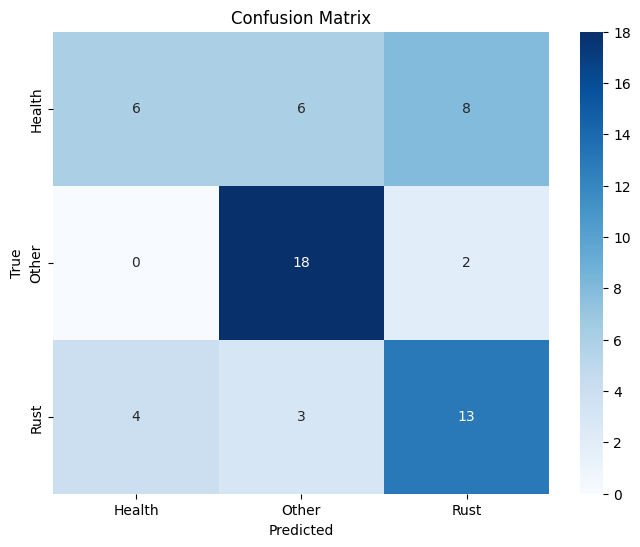


Classification Report:
              precision    recall  f1-score   support

      Health       0.60      0.30      0.40        20
       Other       0.67      0.90      0.77        20
        Rust       0.57      0.65      0.60        20

    accuracy                           0.62        60
   macro avg       0.61      0.62      0.59        60
weighted avg       0.61      0.62      0.59        60



In [31]:
class_names = ["Health","Other","Rust"]
evaluate_on_test(fusion_model, test_loader, criterion, device, class_names)


In [1]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.plot(epochs, [acc for acc in val_accuracies], label='Test Accuracy Snapshot (same as val)', linestyle='--', marker='x')
plt.plot(epochs, [None if i >= len(val_accuracies) else val_accuracies[i] for i in range(num_epochs)],
         label='(Simulated) Train Accuracy Line', linestyle=':', color='gray')

NameError: name 'num_epochs' is not defined

# Hybrid-SSRN-ViT Architecture-For-Hyperspectral-Image-Classification

In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from glob import glob
import cv2
import rasterio
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil

In [7]:
processed_dataset_path = "/kaggle/working/processed_images"  # where processed npy files were saved
split_dataset_path = "/kaggle/working/split_dataset"   

In [16]:
import os
import glob
import torch
import numpy as np
import torchvision.transforms as T
import torchvision.transforms.functional as TF

# -------------------------------
# Custom Transform Definitions
# -------------------------------

class TensorResize:
    """Resizes a tensor image to the target size."""
    def __init__(self, size):
        self.size = size  # e.g. (128, 128) or (224, 224)
    def __call__(self, img):
        # img is expected to be a tensor of shape (C, H, W)
        return torch.nn.functional.interpolate(
            img.unsqueeze(0), size=self.size, mode='bilinear', align_corners=False
        ).squeeze(0)

class RandomHorizontalFlipTensor:
    """Randomly horizontally flips a tensor image with probability p."""
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, img):
        if torch.rand(1).item() < self.p:
            return torch.flip(img, dims=[-1])
        return img

class RandomVerticalFlipTensor:
    """Randomly vertically flips a tensor image with probability p."""
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, img):
        if torch.rand(1).item() < self.p:
            return torch.flip(img, dims=[-2])
        return img

class RandomRotationTensor:
    """Randomly rotates a tensor image by an angle between -max_angle and max_angle degrees."""
    def __init__(self, max_angle=30):
        self.max_angle = max_angle
    def __call__(self, img):
        angle = torch.empty(1).uniform_(-self.max_angle, self.max_angle).item()
        return TF.rotate(img, angle)

class AddGaussianNoise:
    """Adds Gaussian noise to a tensor image."""
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std
    def __call__(self, img):
        noise = torch.randn_like(img) * self.std + self.mean
        return img + noise

class RandomContrastTensor:
    """Randomly adjusts contrast for a tensor image by a factor chosen uniformly."""
    def __init__(self, lower=0.7, upper=1.3):
        self.lower = lower
        self.upper = upper
    def __call__(self, img):
        factor = torch.empty(1).uniform_(self.lower, self.upper).item()
        mean = torch.mean(img, dim=[1,2], keepdim=True)
        return (img - mean) * factor + mean

# -------------------------------
# AgricultureHSIDataset Definition
# -------------------------------

class AgricultureHSIDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Directory with images in subdirectories per category.
            transform (callable, optional): Optional transform to be applied on a tensor sample.
        """
        # If no transform is provided, use the default augmentation pipeline.
        if transform is None:
            transform = T.Compose([
                TensorResize((224, 224)),
                RandomHorizontalFlipTensor(p=0.5),
                RandomVerticalFlipTensor(p=0.5),
                RandomRotationTensor(max_angle=30),
                AddGaussianNoise(mean=0.0, std=0.05),
                RandomContrastTensor(lower=0.8, upper=1.2)
            ])
        self.transform = transform
        self.root_dir = root_dir
        # Build list of files along with labels
        self.image_paths = []
        self.labels = []
        # Mapping for categories to integers; update keys if folder names differ
        self.label_mapping = {"Health": 0, "Rust": 1, "Other": 2}
        categories = os.listdir(root_dir)
        for cat in categories:
            cat_path = os.path.join(root_dir, cat)
            if os.path.isdir(cat_path):
                # Expecting npy files in each category folder.
                for f in glob.glob(os.path.join(cat_path, "*.npy")):
                    self.image_paths.append(f)
                    self.labels.append(self.label_mapping[cat])
                    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load the processed npy file. Each image is expected to be stored as (bands, H, W)
        image = np.load(self.image_paths[idx]).astype(np.float32)
        label = self.labels[idx]
        # Convert numpy array to torch tensor
        image = torch.tensor(image)
        # Apply transformations if available
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)


In [17]:
batch_size = 16

train_dataset = AgricultureHSIDataset(os.path.join(split_dataset_path, "train"))
val_dataset   = AgricultureHSIDataset(os.path.join(split_dataset_path, "val"))
test_dataset  = AgricultureHSIDataset(os.path.join(split_dataset_path, "test"))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 480, Val samples: 60, Test samples: 60


In [19]:
SELECTED_BANDS = 100  # Ensure this matches the band selection used during processing

class SSRN(nn.Module):
    def __init__(self, in_channels, num_features=64):
        super(SSRN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, num_features, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(num_features)
        self.relu  = nn.ReLU()
        # Residual block
        self.res_block = nn.Sequential(
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features),
            nn.ReLU(),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features)
        )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        res = self.res_block(out)
        out = self.relu(out + res)
        return out

class ViTHead(nn.Module):
    def __init__(self, in_features, num_classes, embed_dim=256, num_heads=4, num_layers=2):
        super(ViTHead, self).__init__()
        # A convolutional patch embedding layer
        self.patch_embed = nn.Conv2d(in_features, embed_dim, kernel_size=3, stride=2, padding=1)
        # Transformer encoder block
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # x shape: (batch_size, channels, H, W)
        x = self.patch_embed(x)   # Now: (batch_size, embed_dim, H', W')
        batch_size, embed_dim, H_new, W_new = x.shape
        # Flatten spatial dimensions into patches
        x = x.flatten(2).transpose(1, 2)  # (batch_size, num_patches, embed_dim)
        x = self.transformer_encoder(x)
        # Aggregate features across patches (simple average)
        x = x.mean(dim=1)
        logits = self.classifier(x)
        return logits

# Full hybrid SSRN-ViT model combining the spectral-spatial extractor and ViT head.
class SSRN_ViT(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SSRN_ViT, self).__init__()
        self.ssrn = SSRN(in_channels)
        # The SSRN is configured to output 64 channels.
        self.vit_head = ViTHead(in_features=64, num_classes=num_classes)

    def forward(self, x):
        features = self.ssrn(x)
        logits = self.vit_head(features)
        return logits

In [24]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)
model = SSRN_ViT(in_channels=SELECTED_BANDS, num_classes=3)
model = model.to(device)
print(model)

# %% [code]
# Setup loss, optimizer and training parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

# Define training and evaluation loops
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)


cuda:1
SSRN_ViT(
  (ssrn): SSRN(
    (conv1): Conv2d(100, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (res_block): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (vit_head): ViTHead(
    (patch_embed): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )

In [25]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = SSRN_ViT(in_channels=SELECTED_BANDS, num_classes=3)
model = model.to(device)
print(model)

# %% [code]
# Setup loss, optimizer and training parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

# Define training and evaluation loops
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def eval_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return running_loss / len(loader.dataset), 100 * correct / total

SSRN_ViT(
  (ssrn): SSRN(
    (conv1): Conv2d(100, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (res_block): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (vit_head): ViTHead(
    (patch_embed): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
      

In [26]:
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion, device)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.53 GiB. GPU 1 has a total capacity of 14.74 GiB of which 1.20 GiB is free. Process 3981 has 13.54 GiB memory in use. Of the allocated memory 12.17 GiB is allocated by PyTorch, and 1.23 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [23]:
test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

# %% [code]
# Save the trained model
model_save_path = "/kaggle/working/ssrn_vit.pth"
torch.save(model.state_dict(), model_save_path)
print("Model saved as", model_save_path)


KeyboardInterrupt: 